# Comet MLfrom comet_ml import Experiment

In [1]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [2]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [3]:
# experiment.log_parameters(hyper_params)

# Import Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [9]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-5.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.2)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [10]:
len(train_set), len(val_set)

(132471, 33117)

# Architecture and Config

In [11]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [12]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [13]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [14]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [16]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [17]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [18]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [19]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Model-5/RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/2070 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 518/518 [01:20<00:00,  6.45it/s, Epoch=1, LR=2.14e-5, Valid_Loss=20.4]


Valid RMSE: 20.5106143951416
Valid MAE: 15.759513854980469
Valid SMAPE: 0.13945044577121735
Validation Loss Improved (inf ---> 20.5106143951416)



100%|██████████| 518/518 [01:28<00:00,  5.85it/s, Epoch=2, LR=3.52e-5, Valid_Loss=18.5]


Valid RMSE: 18.668001174926758
Valid MAE: 14.415230751037598
Valid SMAPE: 0.1277807056903839
Validation Loss Improved (20.5106143951416 ---> 18.668001174926758)



100%|██████████| 518/518 [01:27<00:00,  5.93it/s, Epoch=3, LR=9.76e-5, Valid_Loss=19.8]


Valid RMSE: 19.936294555664062
Valid MAE: 15.50780200958252
Valid SMAPE: 0.1362774819135666



100%|██████████| 518/518 [01:30<00:00,  5.75it/s, Epoch=4, LR=1.05e-5, Valid_Loss=17.7]


Valid RMSE: 17.84921646118164
Valid MAE: 13.724674224853516
Valid SMAPE: 0.12206348031759262
Validation Loss Improved (18.668001174926758 ---> 17.84921646118164)



100%|██████████| 518/518 [01:25<00:00,  6.05it/s, Epoch=5, LR=5.05e-5, Valid_Loss=17.4]


Valid RMSE: 17.494783401489258
Valid MAE: 13.43936824798584
Valid SMAPE: 0.11948708444833755
Validation Loss Improved (17.84921646118164 ---> 17.494783401489258)



100%|██████████| 518/518 [01:27<00:00,  5.91it/s, Epoch=6, LR=9.05e-5, Valid_Loss=18.2]


Valid RMSE: 18.371721267700195
Valid MAE: 13.998412132263184
Valid SMAPE: 0.12421975284814835



100%|██████████| 518/518 [01:25<00:00,  6.05it/s, Epoch=7, LR=3.42e-6, Valid_Loss=17.2]


Valid RMSE: 17.29460906982422
Valid MAE: 13.125941276550293
Valid SMAPE: 0.11702881753444672
Validation Loss Improved (17.494783401489258 ---> 17.29460906982422)



100%|██████████| 518/518 [01:24<00:00,  6.12it/s, Epoch=8, LR=6.58e-5, Valid_Loss=17.2]


Valid RMSE: 17.376388549804688
Valid MAE: 13.213228225708008
Valid SMAPE: 0.11761543154716492



100%|██████████| 518/518 [01:27<00:00,  5.89it/s, Epoch=9, LR=7.96e-5, Valid_Loss=17.7]


Valid RMSE: 17.80156135559082
Valid MAE: 13.70145034790039
Valid SMAPE: 0.12088486552238464



100%|██████████| 518/518 [01:28<00:00,  5.84it/s, Epoch=10, LR=1e-6, Valid_Loss=16.9]


Valid RMSE: 16.985815048217773
Valid MAE: 12.947436332702637
Valid SMAPE: 0.11479651927947998
Validation Loss Improved (17.29460906982422 ---> 16.985815048217773)



100%|██████████| 518/518 [01:28<00:00,  5.86it/s, Epoch=11, LR=7.96e-5, Valid_Loss=17.1]


Valid RMSE: 17.25595474243164
Valid MAE: 13.082881927490234
Valid SMAPE: 0.11662620306015015



100%|██████████| 518/518 [01:24<00:00,  6.16it/s, Epoch=12, LR=6.58e-5, Valid_Loss=17]  


Valid RMSE: 17.186141967773438
Valid MAE: 13.07349681854248
Valid SMAPE: 0.11631083488464355



100%|██████████| 518/518 [01:24<00:00,  6.16it/s, Epoch=13, LR=3.42e-6, Valid_Loss=16.5]


Valid RMSE: 16.675500869750977
Valid MAE: 12.668895721435547
Valid SMAPE: 0.1130538135766983
Validation Loss Improved (16.985815048217773 ---> 16.675500869750977)



100%|██████████| 518/518 [01:23<00:00,  6.20it/s, Epoch=14, LR=9.05e-5, Valid_Loss=16.7]


Valid RMSE: 16.851219177246094
Valid MAE: 12.782903671264648
Valid SMAPE: 0.11388333141803741



100%|██████████| 518/518 [01:24<00:00,  6.11it/s, Epoch=15, LR=5.05e-5, Valid_Loss=16.7]


Valid RMSE: 16.854656219482422
Valid MAE: 12.860440254211426
Valid SMAPE: 0.1148558184504509



100%|██████████| 518/518 [01:24<00:00,  6.10it/s, Epoch=16, LR=1.05e-5, Valid_Loss=16.5]


Valid RMSE: 16.660972595214844
Valid MAE: 12.562767028808594
Valid SMAPE: 0.11200427263975143
Validation Loss Improved (16.675500869750977 ---> 16.660972595214844)



100%|██████████| 518/518 [01:25<00:00,  6.06it/s, Epoch=17, LR=9.76e-5, Valid_Loss=17.3]


Valid RMSE: 17.40299415588379
Valid MAE: 13.24433422088623
Valid SMAPE: 0.11699016392230988



100%|██████████| 518/518 [01:20<00:00,  6.41it/s, Epoch=18, LR=3.52e-5, Valid_Loss=16.5]


Valid RMSE: 16.66423988342285
Valid MAE: 12.529438018798828
Valid SMAPE: 0.11176000535488129



100%|██████████| 518/518 [01:23<00:00,  6.18it/s, Epoch=19, LR=2.14e-5, Valid_Loss=16.1]


Valid RMSE: 16.20494270324707
Valid MAE: 12.259345054626465
Valid SMAPE: 0.10950729250907898
Validation Loss Improved (16.660972595214844 ---> 16.20494270324707)



100%|██████████| 518/518 [01:22<00:00,  6.26it/s, Epoch=20, LR=0.0001, Valid_Loss=16.4]


Valid RMSE: 16.52769660949707
Valid MAE: 12.439109802246094
Valid SMAPE: 0.11084557324647903



100%|██████████| 518/518 [01:22<00:00,  6.29it/s, Epoch=21, LR=2.14e-5, Valid_Loss=16.4]


Valid RMSE: 16.548229217529297
Valid MAE: 12.514825820922852
Valid SMAPE: 0.11161121726036072



100%|██████████| 518/518 [01:22<00:00,  6.30it/s, Epoch=22, LR=3.52e-5, Valid_Loss=16]  


Valid RMSE: 16.169023513793945
Valid MAE: 12.174068450927734
Valid SMAPE: 0.10878212004899979
Validation Loss Improved (16.20494270324707 ---> 16.169023513793945)



100%|██████████| 518/518 [01:22<00:00,  6.24it/s, Epoch=23, LR=9.76e-5, Valid_Loss=16.3]


Valid RMSE: 16.460859298706055
Valid MAE: 12.524683952331543
Valid SMAPE: 0.11136407405138016



100%|██████████| 518/518 [01:24<00:00,  6.11it/s, Epoch=24, LR=1.05e-5, Valid_Loss=16.1]


Valid RMSE: 16.205963134765625
Valid MAE: 12.183097839355469
Valid SMAPE: 0.108798086643219



100%|██████████| 518/518 [01:23<00:00,  6.24it/s, Epoch=25, LR=5.05e-5, Valid_Loss=16]  


Valid RMSE: 16.15766143798828
Valid MAE: 12.125844955444336
Valid SMAPE: 0.10819555819034576
Validation Loss Improved (16.169023513793945 ---> 16.15766143798828)



100%|██████████| 518/518 [01:26<00:00,  5.97it/s, Epoch=26, LR=9.05e-5, Valid_Loss=16.2]


Valid RMSE: 16.289026260375977
Valid MAE: 12.301234245300293
Valid SMAPE: 0.10966889560222626



100%|██████████| 518/518 [01:24<00:00,  6.16it/s, Epoch=27, LR=3.42e-6, Valid_Loss=15.9]


Valid RMSE: 15.980484962463379
Valid MAE: 12.0535888671875
Valid SMAPE: 0.10773630440235138
Validation Loss Improved (16.15766143798828 ---> 15.980484962463379)



100%|██████████| 518/518 [01:25<00:00,  6.09it/s, Epoch=28, LR=6.58e-5, Valid_Loss=15.9]


Valid RMSE: 16.02764320373535
Valid MAE: 12.05967903137207
Valid SMAPE: 0.10784275084733963



100%|██████████| 518/518 [01:22<00:00,  6.24it/s, Epoch=29, LR=7.96e-5, Valid_Loss=16.1]


Valid RMSE: 16.295093536376953
Valid MAE: 12.151217460632324
Valid SMAPE: 0.10852303355932236



100%|██████████| 518/518 [01:23<00:00,  6.21it/s, Epoch=30, LR=1e-6, Valid_Loss=15.8]


Valid RMSE: 15.90001106262207
Valid MAE: 11.875904083251953
Valid SMAPE: 0.10623805969953537
Validation Loss Improved (15.980484962463379 ---> 15.90001106262207)



100%|██████████| 518/518 [01:25<00:00,  6.05it/s, Epoch=31, LR=7.96e-5, Valid_Loss=16.2]


Valid RMSE: 16.341899871826172
Valid MAE: 12.293679237365723
Valid SMAPE: 0.10939472168684006



100%|██████████| 518/518 [01:23<00:00,  6.23it/s, Epoch=32, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.950411796569824
Valid MAE: 11.927701950073242
Valid SMAPE: 0.10698992758989334



100%|██████████| 518/518 [01:24<00:00,  6.14it/s, Epoch=33, LR=3.42e-6, Valid_Loss=15.6]


Valid RMSE: 15.751435279846191
Valid MAE: 11.80170726776123
Valid SMAPE: 0.10543856769800186
Validation Loss Improved (15.90001106262207 ---> 15.751435279846191)



100%|██████████| 518/518 [01:24<00:00,  6.10it/s, Epoch=34, LR=9.05e-5, Valid_Loss=16.2]


Valid RMSE: 16.302064895629883
Valid MAE: 12.333473205566406
Valid SMAPE: 0.11003579944372177



100%|██████████| 518/518 [01:24<00:00,  6.16it/s, Epoch=35, LR=5.05e-5, Valid_Loss=15.7]


Valid RMSE: 15.822379112243652
Valid MAE: 11.79051685333252
Valid SMAPE: 0.10554548352956772



100%|██████████| 518/518 [01:24<00:00,  6.13it/s, Epoch=36, LR=1.05e-5, Valid_Loss=15.6]


Valid RMSE: 15.70521354675293
Valid MAE: 11.767064094543457
Valid SMAPE: 0.10531706362962723
Validation Loss Improved (15.751435279846191 ---> 15.70521354675293)



100%|██████████| 518/518 [01:24<00:00,  6.13it/s, Epoch=37, LR=9.76e-5, Valid_Loss=15.7]


Valid RMSE: 15.832347869873047
Valid MAE: 11.821748733520508
Valid SMAPE: 0.1057998463511467



100%|██████████| 518/518 [01:24<00:00,  6.11it/s, Epoch=38, LR=3.52e-5, Valid_Loss=15.8]


Valid RMSE: 15.91015911102295
Valid MAE: 11.901350021362305
Valid SMAPE: 0.10629311203956604



100%|██████████| 518/518 [01:24<00:00,  6.15it/s, Epoch=39, LR=2.14e-5, Valid_Loss=15.3]


Valid RMSE: 15.454631805419922
Valid MAE: 11.581295013427734
Valid SMAPE: 0.10403114557266235
Validation Loss Improved (15.70521354675293 ---> 15.454631805419922)



100%|██████████| 518/518 [01:23<00:00,  6.20it/s, Epoch=40, LR=0.0001, Valid_Loss=15.9]


Valid RMSE: 16.037628173828125
Valid MAE: 12.016402244567871
Valid SMAPE: 0.10748802125453949



100%|██████████| 518/518 [01:24<00:00,  6.15it/s, Epoch=41, LR=2.14e-5, Valid_Loss=15.6]


Valid RMSE: 15.771378517150879
Valid MAE: 11.733331680297852
Valid SMAPE: 0.10506949573755264



100%|██████████| 518/518 [01:23<00:00,  6.24it/s, Epoch=42, LR=3.52e-5, Valid_Loss=15.3]


Valid RMSE: 15.450148582458496
Valid MAE: 11.585116386413574
Valid SMAPE: 0.10390232503414154
Validation Loss Improved (15.454631805419922 ---> 15.450148582458496)



100%|██████████| 518/518 [01:24<00:00,  6.16it/s, Epoch=43, LR=9.76e-5, Valid_Loss=16.2]


Valid RMSE: 16.35823631286621
Valid MAE: 12.279985427856445
Valid SMAPE: 0.10934886336326599



100%|██████████| 518/518 [01:21<00:00,  6.32it/s, Epoch=44, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.679511070251465
Valid MAE: 11.711176872253418
Valid SMAPE: 0.10469239205121994



100%|██████████| 518/518 [01:23<00:00,  6.17it/s, Epoch=45, LR=5.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.565376281738281
Valid MAE: 11.60293197631836
Valid SMAPE: 0.10358035564422607



100%|██████████| 518/518 [01:25<00:00,  6.04it/s, Epoch=46, LR=9.05e-5, Valid_Loss=15.8]


Valid RMSE: 16.008045196533203
Valid MAE: 11.893221855163574
Valid SMAPE: 0.10684498399496078



100%|██████████| 518/518 [01:23<00:00,  6.19it/s, Epoch=47, LR=3.42e-6, Valid_Loss=15.4]


Valid RMSE: 15.566206932067871
Valid MAE: 11.514723777770996
Valid SMAPE: 0.10309211909770966



100%|██████████| 518/518 [01:23<00:00,  6.23it/s, Epoch=48, LR=6.58e-5, Valid_Loss=15.4]


Valid RMSE: 15.54532527923584
Valid MAE: 11.53000259399414
Valid SMAPE: 0.10328983515501022



100%|██████████| 518/518 [01:23<00:00,  6.24it/s, Epoch=49, LR=7.96e-5, Valid_Loss=16]  


Valid RMSE: 16.169530868530273
Valid MAE: 12.225653648376465
Valid SMAPE: 0.10839542746543884



100%|██████████| 518/518 [01:21<00:00,  6.35it/s, Epoch=50, LR=1e-6, Valid_Loss=15.4]


Valid RMSE: 15.487320899963379
Valid MAE: 11.557937622070312
Valid SMAPE: 0.10376754403114319



100%|██████████| 518/518 [01:25<00:00,  6.09it/s, Epoch=51, LR=7.96e-5, Valid_Loss=15.2]


Valid RMSE: 15.29552936553955
Valid MAE: 11.39787769317627
Valid SMAPE: 0.10198407620191574
Validation Loss Improved (15.450148582458496 ---> 15.29552936553955)



100%|██████████| 518/518 [01:25<00:00,  6.04it/s, Epoch=52, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.946060180664062
Valid MAE: 11.884468078613281
Valid SMAPE: 0.10620590299367905



100%|██████████| 518/518 [01:22<00:00,  6.28it/s, Epoch=53, LR=3.42e-6, Valid_Loss=15.3]


Valid RMSE: 15.421507835388184
Valid MAE: 11.47225284576416
Valid SMAPE: 0.10291188955307007



100%|██████████| 518/518 [01:20<00:00,  6.43it/s, Epoch=54, LR=9.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.584202766418457
Valid MAE: 11.64018440246582
Valid SMAPE: 0.10370375961065292



100%|██████████| 518/518 [01:24<00:00,  6.12it/s, Epoch=55, LR=5.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.68812084197998
Valid MAE: 11.66604995727539
Valid SMAPE: 0.104241281747818



100%|██████████| 518/518 [01:23<00:00,  6.23it/s, Epoch=56, LR=1.05e-5, Valid_Loss=15.1]


Valid RMSE: 15.23883056640625
Valid MAE: 11.363794326782227
Valid SMAPE: 0.10213256627321243
Validation Loss Improved (15.29552936553955 ---> 15.23883056640625)



100%|██████████| 518/518 [01:25<00:00,  6.04it/s, Epoch=57, LR=9.76e-5, Valid_Loss=15.4]


Valid RMSE: 15.564784049987793
Valid MAE: 11.64881706237793
Valid SMAPE: 0.10404534637928009



100%|██████████| 518/518 [01:24<00:00,  6.12it/s, Epoch=58, LR=3.52e-5, Valid_Loss=15.3]


Valid RMSE: 15.47840690612793
Valid MAE: 11.502578735351562
Valid SMAPE: 0.10299597680568695



100%|██████████| 518/518 [01:23<00:00,  6.18it/s, Epoch=59, LR=2.14e-5, Valid_Loss=15.1]


Valid RMSE: 15.231456756591797
Valid MAE: 11.316143989562988
Valid SMAPE: 0.10163044929504395
Validation Loss Improved (15.23883056640625 ---> 15.231456756591797)



100%|██████████| 518/518 [01:22<00:00,  6.29it/s, Epoch=60, LR=0.0001, Valid_Loss=15.6]


Valid RMSE: 15.71627140045166
Valid MAE: 11.638960838317871
Valid SMAPE: 0.10400114953517914



100%|██████████| 518/518 [01:20<00:00,  6.40it/s, Epoch=61, LR=2.14e-5, Valid_Loss=15.4]


Valid RMSE: 15.49184799194336
Valid MAE: 11.518491744995117
Valid SMAPE: 0.10344648361206055



100%|██████████| 518/518 [01:21<00:00,  6.37it/s, Epoch=62, LR=3.52e-5, Valid_Loss=15.1]


Valid RMSE: 15.233662605285645
Valid MAE: 11.29719352722168
Valid SMAPE: 0.10126376152038574



100%|██████████| 518/518 [01:19<00:00,  6.50it/s, Epoch=63, LR=9.76e-5, Valid_Loss=15.5]


Valid RMSE: 15.683871269226074
Valid MAE: 11.694307327270508
Valid SMAPE: 0.10436634719371796



100%|██████████| 518/518 [01:25<00:00,  6.06it/s, Epoch=64, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.438858985900879
Valid MAE: 11.400920867919922
Valid SMAPE: 0.10240114480257034



100%|██████████| 518/518 [01:25<00:00,  6.06it/s, Epoch=65, LR=5.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.506612777709961
Valid MAE: 11.494974136352539
Valid SMAPE: 0.1028108075261116



100%|██████████| 518/518 [01:22<00:00,  6.24it/s, Epoch=66, LR=9.05e-5, Valid_Loss=15.7]


Valid RMSE: 15.859121322631836
Valid MAE: 11.76550006866455
Valid SMAPE: 0.10559505224227905



100%|██████████| 518/518 [01:19<00:00,  6.51it/s, Epoch=67, LR=3.42e-6, Valid_Loss=15.2]


Valid RMSE: 15.321928977966309
Valid MAE: 11.30931282043457
Valid SMAPE: 0.1014978215098381



 80%|████████  | 1662/2070 [07:33<01:51,  3.67it/s, Epoch=68, LR=5.36e-5, Train_Loss=13.7]

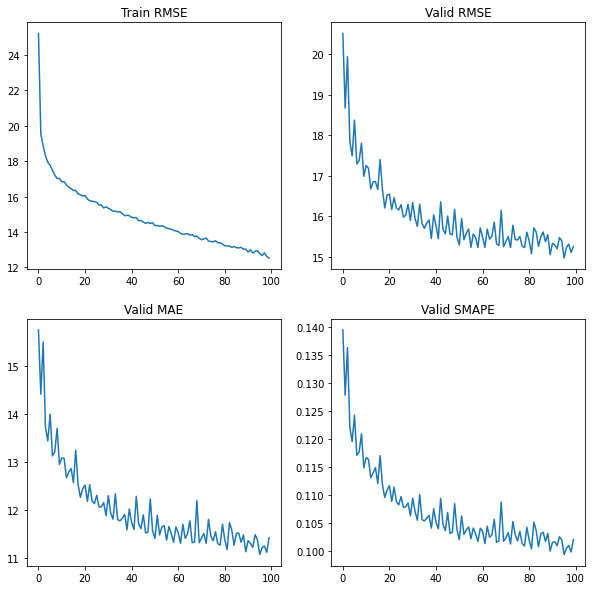

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')